In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
import pandas as pd

In [4]:
import numpy as np

In [5]:
import cv2

In [6]:
import matplotlib.pyplot as plt
import json

In [7]:
input_image = cv2.imread('/media/karthikragunath/Personal-Data/SemanticSceneUnderstanding/data/out_rgb/106195.png', cv2.COLOR_BGR2RGB)
with open('/media/karthikragunath/Personal-Data/SemanticSceneUnderstanding/data/out_bbox/106195.txt', 'r') as fp:
    input_image_dict = json.load(fp)

In [8]:
input_image_dict

{'bboxes': [[[258.5264480677576, 305.8904957608805],
   [312.2768240729949, 342.96263330383925]]],
 'vehicle_class': [0],
 'removed_bboxes': [],
 'removed_vehicle_class': []}

In [9]:
bbox_left_lower = tuple([int(input_image_dict['bboxes'][0][0][0]), int(input_image_dict['bboxes'][0][0][1])])
bbox_right_upper = tuple([int(input_image_dict['bboxes'][0][1][0]), int(input_image_dict['bboxes'][0][1][1])])                  

In [10]:
bbox_left_lower

(258, 305)

In [11]:
bbox_right_upper

(312, 342)

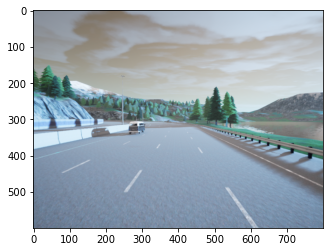

In [12]:
plt.imshow(input_image)

In [13]:
cv2.rectangle(input_image, bbox_left_lower, bbox_right_upper, (0,255,0), 2)

array([[[132, 140, 149],
        [132, 139, 149],
        [133, 140, 150],
        ...,
        [197, 214, 230],
        [197, 215, 231],
        [198, 215, 231]],

       [[132, 139, 149],
        [132, 140, 150],
        [132, 139, 150],
        ...,
        [198, 215, 231],
        [198, 215, 231],
        [197, 215, 230]],

       [[132, 140, 150],
        [132, 140, 150],
        [133, 141, 151],
        ...,
        [198, 216, 231],
        [198, 215, 231],
        [197, 215, 231]],

       ...,

       [[100, 119, 142],
        [ 99, 120, 144],
        [ 99, 122, 146],
        ...,
        [108, 131, 159],
        [112, 133, 161],
        [111, 131, 159]],

       [[101, 124, 148],
        [100, 123, 147],
        [101, 123, 147],
        ...,
        [110, 135, 162],
        [111, 135, 163],
        [114, 135, 164]],

       [[ 98, 123, 146],
        [ 99, 123, 145],
        [ 99, 122, 144],
        ...,
        [109, 136, 163],
        [109, 135, 163],
        [109, 135, 164]]

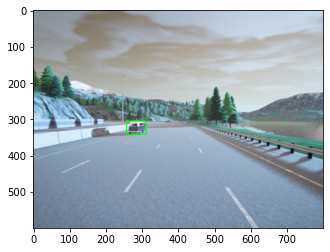

In [14]:
plt.imshow(input_image)
plt.savefig('test_image.png')

In [15]:
plt.close()

In [16]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [17]:
import torch
import matplotlib.pyplot as plt

BATCH_SIZE = 4 # increase / decrease according to GPU memeory
RESIZE_TO = 512 # resize the image for training and transforms
NUM_EPOCHS = 5 # number of epochs to train for

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = 'data/out_rgb'
# validation images and XML files directory
VALID_DIR = 'data/out_rgb'

# classes: 0 index is reserved for background
CLASSES = [
    '0', '1', '2', '3'
]
NUM_CLASSES = 4

# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = False

# location to save model and plots
OUT_DIR = '../outputs'
SAVE_PLOTS_EPOCH = 2 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 2 # save model after these many epochs

In [18]:
import albumentations as A
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2
from config import DEVICE, CLASSES as classes
# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [19]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [20]:
# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })
# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [21]:
def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box in boxes:
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
            cv2.imshow('Transformed image', sample)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

In [22]:
import torch
import cv2
import numpy as np
import os
import glob as glob
from xml.etree import ElementTree as et
# from config import CLASSES, RESIZE_TO, TRAIN_DIR, VALID_DIR, BATCH_SIZE
from config import CLASSES, RESIZE_TO, BATCH_SIZE
from torch.utils.data import Dataset, DataLoader
from utils import collate_fn, get_train_transform, get_valid_transform

In [160]:
# the dataset class
class MicrocontrollerDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order    
        self.image_paths = glob.glob(f"{self.dir_path}/*.png")
        self.all_images = [image_path.split('/')[-1].split('.')[0] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

        # FileNames Dictionary
        self.filenames = dict()
        for sub_dir, dir_name, files in os.walk("data/out_bbox/"):
            for file in files:
                try:
                    with open("data/out_bbox/" + file, 'r') as fp:
                        file = file.split('.')[0]
                        self.filenames[file] = json.load(fp)
                except Exception as e:
                    pass
                    
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name + '.png')
        # read the image
        print(image_path)
        # image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image = cv2.imread(image_path)
        # plt.imshow(image)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        # plt.imshow(image_resized)
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        image_annotation_dict = self.filenames[image_name]
        
        boxes = []
        if image_annotation_dict["bboxes"]:
            for box_coordinates in filenames[image_name]["bboxes"]:
                if box_coordinates:
                    xmin = box_coordinates[0][0]
                    ymin = box_coordinates[0][1]
                    xmax = box_coordinates[1][0]
                    ymax = box_coordinates[1][1]
                    
                    xmin_final = (xmin/image_width)*self.width
                    xmax_final = (xmax/image_width)*self.width
                    ymin_final = (ymin/image_height)*self.height
                    ymax_final = (ymax/image_height)*self.height
                    boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
        labels = image_annotation_dict["vehicle_class"]

        num_objs = len(boxes)
        # if not boxes:
        #     boxes.append([0,0,0,0])
        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        print(boxes)
        # area of the bounding boxes
        if len(boxes) != 0:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.tensor([0])
        # no crowd instances
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        # apply the image transforms
        # print(labels)
        # print(boxes)
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = boxes,
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            print("Box shape after transformation:", target['boxes'].shape)
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

In [161]:
import os
import json
filenames = dict()
# all_box_cordinates = []
for sub_dir, dir_name, files in os.walk("data/out_bbox/"):
    for file in files:
        # filenames.append(file)
        try:
            with open("data/out_bbox/" + file, 'r') as fp:
                file = file.split('.')[0]
                filenames[file] = json.load(fp)
        except Exception as e:
            # print(dir_name, file)
            pass
list(filenames.keys())[:5]

for box_coordinates in filenames["105995"]["bboxes"]:
    print(box_coordinates)
    if box_coordinates:
        xmin = box_coordinates[0][0]
        ymin = box_coordinates[0][1]
        xmax = box_coordinates[1][0]
        ymax = box_coordinates[1][1]
        print(xmin, ymin, xmax, ymax)
        # print(box[0])
        # x_max, y_max = box[1]
        # print(x_min, x_max, y_min, y_max)
        
class_set = set()
for key, val_dict in filenames.items():
    class_set.update(val_dict["vehicle_class"])
print(class_set)

boxes = [[1,2,3,4], [0,0,4,4]]
boxes = torch.as_tensor(boxes, dtype=torch.float32)
iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
print(iscrowd)
area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
print(area)
print(boxes[:, 3])
print(boxes[:, 1])
# boxes = []
# boxes = torch.as_tensor(boxes, dtype=torch.float32)
# iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
# print(iscrowd)

[[253.889655653831, 306.58146939539637], [277.14568326718637, 319.3496600127334]]
253.889655653831 306.58146939539637 277.14568326718637 319.3496600127334
[[229.25304453890132, 306.74947544989004], [254.01779587321496, 318.9538590887852]]
229.25304453890132 306.74947544989004 254.01779587321496 318.9538590887852
[[86.5873071826761, 314.0647101327736], [117.12310585613795, 330.7682771308912]]
86.5873071826761 314.0647101327736 117.12310585613795 330.7682771308912
[[252.71368192031562, 306.0959690418662], [309.3647964467607, 344.77550581449395]]
252.71368192031562 306.0959690418662 309.3647964467607 344.77550581449395
{0, 1, 2, 3}
tensor([0, 0])
tensor([ 4., 16.])
tensor([4., 4.])
tensor([2., 0.])


In [162]:
filenames['105855']

{'bboxes': [[[195.77481682519064, 303.03618581911525],
   [247.93312444594955, 326.47741096889905]],
  [[247.4331558530118, 306.25640030869926],
   [306.590168251729, 346.2791795874659]]],
 'vehicle_class': [1, 0],
 'removed_bboxes': [[[277.3736058386294, 305.7221139508896],
   [284.7669786002233, 312.02981722521616]]],
 'removed_vehicle_class': [2]}

In [163]:
# # loc_dir_path = "/media/karthikragunath/Personal-Data/SemanticSceneUnderstanding/data/out_rgb"
# loc_dir_path = "data/out_rgb"
# image_paths_loc = glob.glob(f"{loc_dir_path}/*.png")
# all_images_loc = [image_path.split('/')[-1].split('.')[0] for image_path in image_paths_loc]
# all_images_loc = sorted(all_images_loc)
# print(all_images_loc)
# !pwd

In [164]:
# prepare the final datasets and data loaders
train_dataset = MicrocontrollerDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
valid_dataset = MicrocontrollerDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 2779
Number of validation samples: 2779



In [165]:
trainset_0 = train_dataset[0]

data/out_rgb/105855.png
tensor([[125.2959, 258.5909, 158.6772, 278.5941],
        [158.3572, 261.3388, 196.2177, 295.4916]])
Box shape after transformation: torch.Size([2, 4])


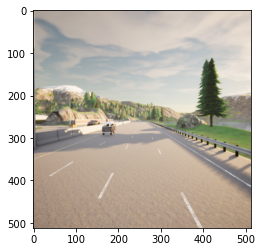

In [166]:
plt.imshow(trainset_0[0].permute(1,2,0))

[[125.29588276812201, 258.590878565645, 158.6771996454077, 278.5940573601272], [158.35721974592755, 261.33879493009005, 196.21770768110656, 295.4915665813042]]
[1, 0]
Box: tensor([125.2959, 258.5909, 158.6772, 278.5941], dtype=torch.float64) Label: tensor(1)
Box: tensor([158.3572, 261.3388, 196.2177, 295.4916], dtype=torch.float64) Label: tensor(0)


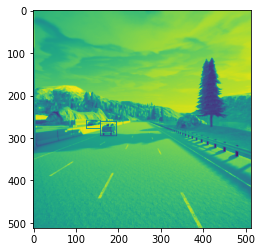

In [167]:
image_path = "data/out_rgb/105855.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image_resized = cv2.resize(image, (512, 512))
image_resized /= 255.0
# plt.imshow(image_resized)

# get the height and width of the image
image_width = image.shape[1]
image_height = image.shape[0]
width = 512
height = 512

boxes = []
for box_coordinates in filenames["105855"]["bboxes"]:
    if box_coordinates:
        xmin = box_coordinates[0][0]
        ymin = box_coordinates[0][1]
        xmax = box_coordinates[1][0]
        ymax = box_coordinates[1][1]
        xmin_final = (xmin/image_width)*width
        xmax_final = (xmax/image_width)*width
        ymin_final = (ymin/image_height)*height
        ymax_final = (ymax/image_height)*height
        boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
        
print(boxes)

labels = filenames["105855"]["vehicle_class"]
print(labels)

boxes = torch.as_tensor(boxes, dtype=torch.float32)
labels = torch.as_tensor(labels, dtype=torch.int64)
transforms = get_train_transform()
sample = transforms(image = image_resized,
                         bboxes = boxes,
                         labels = labels)

# print("Shape 1:", np.shape(sample['image']))
# # plt.imshow(sample['image'].permute(1,2,0))
# print("Shape 2:", np.shape(sample['image']))
# target = dict()
# target['boxes'] = torch.Tensor(sample['bboxes'])
# box = target['boxes'][0]
# sample_image = sample['image'].permute(1,2,0)
# label = sample['labels'][0]
# sample_image = cv2.cvtColor(np.float32(sample_image), cv2.COLOR_RGB2GRAY)
# cv2.rectangle(
#     sample_image, 
#     (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
#     (0, 255, 0), 1
# )
# # cv2.putText(
# #     sample_image, label, (int(box[0]), int(box[1]-5)), 
# #     cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
# # )
# plt.imshow(sample_image)


sampled_image = sample['image'].permute(1,2,0)
boxes = torch.tensor(sample['bboxes'])
labels = sample['labels']
sampled_image = cv2.cvtColor(np.float32(sampled_image), cv2.COLOR_RGB2GRAY)
for box, label in zip(boxes, labels):
    print("Box:", box, "Label:", label)
    cv2.rectangle(sampled_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                  (0, 255, 0), 1)
plt.imshow(sampled_image)
plt.savefig('transformed_image.png')

In [168]:
# train_dataset.filenames

data/out_rgb/106055.png
tensor([[ 33.4272, 268.1956,  85.0205, 295.2755],
        [ 12.3033, 267.8634,  63.3503, 292.0543],
        [162.8882, 261.1479, 198.5671, 293.7297]])
Box shape after transformation: torch.Size([3, 4])


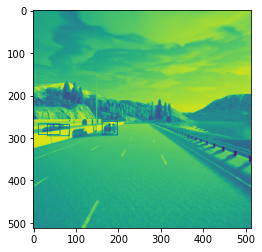

In [169]:
# function to visualize a single sample
def visualize_sample(image, target):
    # box = target['boxes'][0]
    # label = target['labels'][0]
    # # image = cv2.cvtColor(np.float32(image), cv2.COLOR_RGB2GRAY)
    # image = image.permute(1,2,0)
    # cv2.rectangle(
    #     image, 
    #     (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
    #     (0, 255, 0), 1
    # )
    # cv2.putText(
    #     image, label, (int(box[0]), int(box[1]-5)), 
    #     cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
    # )
    
    sampled_image = image.permute(1,2,0)
    boxes = target['boxes']
    labels = target['labels']
    sampled_image = cv2.cvtColor(np.float32(sampled_image), cv2.COLOR_RGB2GRAY)
    for box, label in zip(boxes, labels):
        cv2.rectangle(sampled_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                      (0, 255, 0), 1)
    plt.imshow(sampled_image)
    plt.imshow(sampled_image)
    cv2.waitKey(0)

# NUM_SAMPLES_TO_VISUALIZE = 5
# for i in range(NUM_SAMPLES_TO_VISUALIZE):
#     image, target = train_dataset[i]
#     visualize_sample(image, target)

image, target = train_dataset[10]
visualize_sample(image, target)

In [170]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [171]:
# from config import DEVICE, NUM_CLASSES, NUM_EPOCHS, OUT_DIR
# from config import VISUALIZE_TRANSFORMED_IMAGES
# from config import SAVE_PLOTS_EPOCH, SAVE_MODEL_EPOCH
# from model import create_model
# from utils import Averager
'''
from tqdm.auto import tqdm
'''
from tqdm import tqdm
# from datasets import train_loader, valid_loader
# import torch
# import matplotlib.pyplot as plt
import time
# plt.style.use('ggplot')

In [172]:
# function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [173]:
# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list









  0%|                                                                                                                                                                              | 0/695 [00:00<?, ?it/s]


EPOCH 1 of 5
Training
data/out_rgb/199766.png
tensor([[112.2378, 261.8813, 154.8162, 289.6287]])
Box shape after transformation: torch.Size([1, 4])
data/out_rgb/111735.png
tensor([[153.5780, 263.7655, 167.8911, 273.4693],
        [248.5748, 298.6689, 258.3410, 352.4568]])
Box shape after transformation: torch.Size([2, 4])
data/out_rgb/213106.png
tensor([])
Box shape after transformation: torch.Size([0])
data/out_rgb/211904.png
tensor([[131.8404, 263.5658, 155.3789, 277.7061]])
Box shape after transformation: torch.Size([1, 4])


ValueError: Expected target boxes to be a tensorof shape [N, 4], got torch.Size([0]).

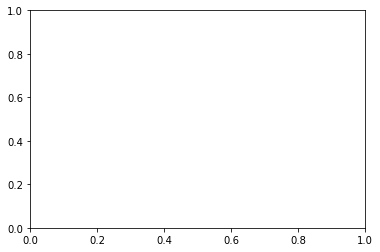

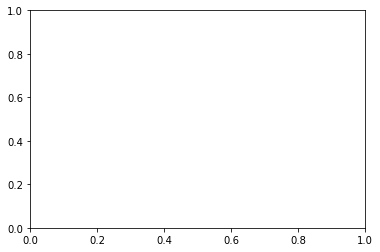

In [174]:
# initialize the model and move to the computation device
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []
# name to save the trained model with
MODEL_NAME = 'model'
# whether to show transformed images from data loader or not
if VISUALIZE_TRANSFORMED_IMAGES:
    from utils import show_tranformed_image
    show_tranformed_image(train_loader)
# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()
    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')

    if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # save loss plots after n epochs
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')

    if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")

    plt.close('all')

In [ ]:
(torch.tensor([])).nelement == 0

In [74]:
len(torch.tensor([])) == 0

True

In [ ]:
# execute datasets.py using Python command from Terminal...
# ... to visualize sample images
# USAGE: python datasets.py
if __name__ == '__main__':
    # sanity check of the Dataset pipeline with sample visualization
    dataset = MicrocontrollerDataset(
        TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES
    )
    print(f"Number of training images: {len(dataset)}")
    
    # function to visualize a single sample
    def visualize_sample(image, target):
        box = target['boxes'][0]
        label = CLASSES[target['labels']]
        cv2.rectangle(
            image, 
            (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
            (0, 255, 0), 1
        )
        cv2.putText(
            image, label, (int(box[0]), int(box[1]-5)), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
        )
        cv2.imshow('Image', image)
        cv2.waitKey(0)
        
    NUM_SAMPLES_TO_VISUALIZE = 5
    for i in range(NUM_SAMPLES_TO_VISUALIZE):
        image, target = dataset[i]
        visualize_sample(image, target)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [37]:
# Sample Code

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# For training
images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)
boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
labels = torch.randint(1, 91, (4, 11))
images = list(image for image in images)
targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)
output = model(images, targets)
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/karthikragunath/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160M/160M [00:09<00:00, 17.0MB/s]
/home/karthikragunath/anaconda3/envs/semantic_scene_understanding/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [38]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

In [4]:
torch.zeros((1,)) == True

tensor([False])

In [5]:
torch.zeros((2,)) == True

tensor([False, False])